# CMU auto-graded notebook

Before you turn these assignments in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE."

---

# Neural Style Transfer

Before you turn this assignment in, make sure everything runs as expected. 


In this assignment, we will implement the style transfer application described in the paper [Leon A. Gatys' paper, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576). 

### Five major steps:
1. Visualize the data and expected outputs
2. Process the data
3. Create the model
4. Define the loss function 
5. Optimize for the loss function and evaluation

Note: [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) is not allowed in this assignment

# Import Packages and Supporting Files


In [1]:
# Import packages
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as k_image
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models 
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [3]:
#Download the Content Image and Style Image
!wget "https://upload.wikimedia.org/wikipedia/commons/c/cd/VanGogh-starry_night.jpg" -O style.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/e/e6/T%C3%BCbingen_Neckarfront_August_2013.jpg" -O content.jpg
!wget "https://raw.githubusercontent.com/10605/data/master/hw4/styleTransfer/my_styled_image.jpg" -O style_output.jpg


--2023-11-15 13:17:00--  https://upload.wikimedia.org/wikipedia/commons/c/cd/VanGogh-starry_night.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 780240 (762K) [image/jpeg]
Saving to: 'style.jpg'

     0K .......... .......... .......... .......... ..........  6% 1.75M 0s
    50K .......... .......... .......... .......... .......... 13% 2.95M 0s
   100K .......... .......... .......... .......... .......... 19% 3.57M 0s
   150K .......... .......... .......... .......... .......... 26% 23.1M 0s
   200K .......... .......... .......... .......... .......... 32% 1.74M 0s
   250K .......... .......... .......... .......... .......... 39% 43.6M 0s
   300K .......... .......... .......... .......... .......... 45% 2.96M 0s
   350K .......... .......... .......... .......... .......... 52% 9.68M 0s
   400K .......... .

In [4]:
# Set path variables here
content_path = 'content.jpg'
style_path = 'style.jpg'
styled_ref='style_output.jpg'

# Visualize the Inputs and the Reference Stylized Output

In [5]:
def resize_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    # img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.LANCZOS)
    img = kp_image.img_to_array(img)
  
    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    return img

In [6]:
def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

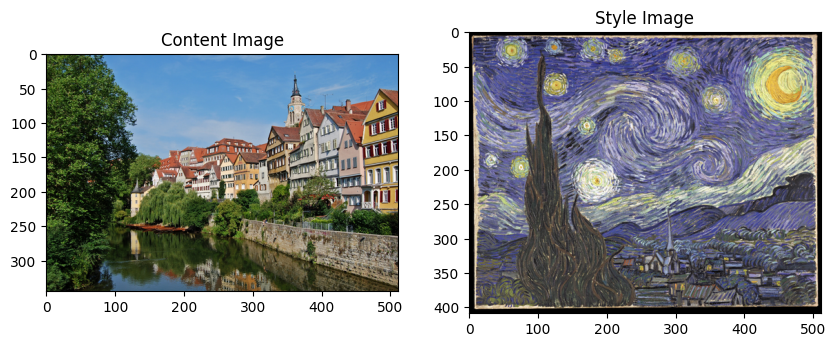

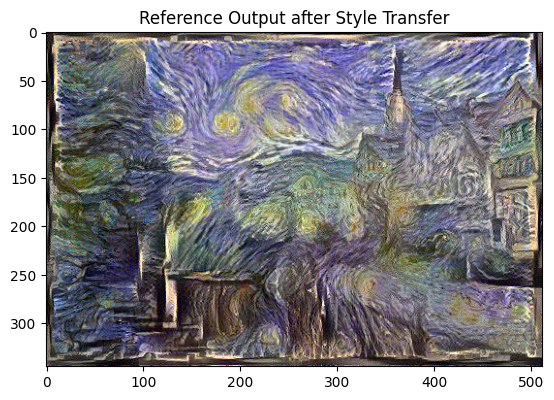

In [7]:
plt.figure(figsize=(10,10))
content = resize_img(content_path).astype('uint8')
style = resize_img(style_path).astype('uint8')
ref_output=resize_img(styled_ref).astype('uint8')
plt.subplot(1, 2, 1)
imshow(content, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()
imshow(ref_output,'Reference Output after Style Transfer')
plt.show()

# Prepare the Data
Let's implement some helper functions that will allow us to load and preprocess our images more easily. We will be using VGG as the backbone model. It is worth noting that VGG is trained on images with each channel normalized by `mean = [103.939, 116.779, 123.68]` and with channels BGR.

In [8]:
def load_and_process_img(path_to_img):
    """
    Load and process the image at the given path

    Note:
      You should load the image using the resize_img function and use
      keras.applications.vgg19.preprocess_input to change the image from
      RGB to BGR format
    
    Args:
      path_to_img (str): Path to the image
    
    Returns:
      numpy.ndarray: The processed image
    """
    
    # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
    img = resize_img(path_to_img)
    # Preprocess them with respect to VGG19 stats
    img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return img
    

In [9]:
# Test load_and_process_img
assert -10> np.mean(load_and_process_img(content_path))> -20

In order to visualize the output image of our model, we need to perform the inverse preprocessing step. Furthermore, since our output image may take its values anywhere between $- \infty$ and $\infty$, we must clip to maintain our values within the 0-255 range.   

In [10]:
def deprocess_img(processed_img):
    """
    Perform inverse processing on the input image

    Note: 
      Check if processed_img is 4 or 3 dimensional, raise expection if less than 3
      else reduce the dimension to 3 by squeezing the appropriate axis and perform
      inverse of preprocessing step. Remember that you need to add
      mean = [103.939, 116.779, 123.68] with channels BGR.
      Also for any image the pixel value should be clipped between 0-255.
    
    Args:
      processed_img (numpy.ndarray): The processed image
    
    Returns:
      numpy.ndarray: The inverse processed image
    """
    
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
    # add mean
    m = np.array([103.939, 116.779, 123.68]).reshape((1,1,3))
    x = np.add(x,m)
    # clip
    x = np.clip(x, 0, 255)
    
    # Cast the output to type np.unint8
    return x.astype(np.uint8)


In [11]:
# Test deprocess_img
content_img_test = load_and_process_img(content_path)
d = deprocess_img(content_img_test)
mean_d = np.mean(d)

assert 200 > mean_d > 50

# Build the Model 
We will load [VGG19](https://keras.io/applications/#vgg19), and feed in our input tensor to the model to extract the feature maps of the content, style, and generated images.


### Extract content and style representations from VGG
For content layers we will use `conv2`  of `block5`.

For style layers we will use `conv1` of each block. For example, `block1_conv1`.


In [12]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.summary()



80134624/80134624 [==============================] - 15s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                           

In [23]:
'''
Define 4 variables:
`content_layers` and `style_layers`: lists containing the names of the blocks to be used
`num_content_layers` and `num_style_layers`: lengths of content_layers and style_layers
'''

# TODO: Uncomment the lines below and replace <FILL IN> with appropriate code

content_layers = ['block5_conv2']

# Style layers we are interested in
style_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = 1
num_style_layers = 5

# YOUR CODE HERE
# raise NotImplementedError()

In [16]:
#Test the content_layers 
assert style_layers[1]=='block2_conv1'
assert num_content_layers==1
assert num_style_layers==5

In order to access the intermediate layers corresponding to our style and content feature maps, we will get the corresponding outputs and use the Keras [**Functional API**](https://keras.io/getting-started/functional-api-guide/). We then define our model with the desired output activations. 


In [24]:
def model_VGG():
    """ 
    Creates our model with access to intermediate layers. 

    Note:
      This function will load the VGG19 model and access the intermediate layers. 
      These layers will then be used to create a new model that will take input image
      and return the representations from these intermediate layers via VGG. 
  
    Returns:
        model: A keras model that takes image inputs and returns the style and 
        content intermediate layer outputs.
    """
    
    # Load a pretrained VGG on Imagenet
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    
    # # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    return models.Model(vgg.input, model_outputs)


## Define the Loss function (content loss + style loss)

### Content Loss

Content loss 

 $$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

where F is the feature representation of the generated image and P is the feature representation
of the content image layer l.



In [25]:
def compute_content_loss(base_content, target):
    """
    Calculate the content loss

    Note:
      You can use tf.reduce_mean
    
    Args:
      base_content (numpy.ndarray): The generated image
      target (numpy.ndarray): The content image
    
    Returns:
      The content loss
    """
    loss = tf.reduce_mean(tf.square(base_content-target))
    return loss

    # YOUR CODE HERE
    # raise NotImplementedError()

In [26]:
# Test the Content Loss Function
content_img=load_and_process_img(content_path)
compute_content_loss(d,content_img).numpy()

assert 30000>compute_content_loss(d,content_img).numpy()>1000

### Style Loss

Given a base input image $x$, the style representation for layer $l$ $G^l$  is the gram matrix of the vectorized feature maps (i.e $G^l_{i,j}$ is the inner product of the vectorized feature map $i$ and the vectorized feature map $j$ in layer $l$). 

Similarly let $A^l$ be the style representation of the style image $a$ in layer $l$. 

Then define the (unnormalized) style loss for layer $l$ as 

$$E_l = \sum_{i,j} (G^l_{i, j} - A^l_{i, j})^2$$

Finally, the total (unnormalized) style loss across all layers is defined as a weighted sum of the style losses of each layer,

$$L_{\text{style}} = \sum_{l \in L} w_l E_l$$

### Computing the style loss
We will first implement a distance metric that will be used when calculating the style loss in `compute_style_loss()` below. 

In [39]:
def gram_matrix(input_tensor):
    """ 
    Create and return the gram matrix for `input_tensor`
    
    Note:
      You'll first have to find the channels then reshape
      the input_tensor, compute gram_matrix and divide it
      by shape of input_tensor

    Args:
      input_tensor (tf.Tensor): The input image of shape (height, width, channels)
    
    Returns:
      tf.Tensor: The gram matrix of shape (channels, channels)
    """

    channels = int(input_tensor.shape[-1])
    
    # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
    a = tf.reshape(input_tensor, (-1,channels))
    gram = tf.matmul(tf.transpose(a), a)
    n = a.shape[0]
    
    # YOUR CODE HERE
    # raise NotImplementedError()
     
    return gram / tf.cast(n, tf.float32)
 

In [40]:
# Test Gram Matrix
sample_tensor_x=tf.constant([[1.,2.,4,2],[1.,2.,4,44.],[2.,2,2.,2],[12.,4.,1,8]])
np_gram=np.mean(gram_matrix(sample_tensor_x).numpy())

assert 200>np_gram>40

sample_tensor= tf.constant(
    [
        [
            [1.,2.],
            [3.,4.],
            [5.,6.],
            [7.,8.]
        ],
        [
            [9.,10.],
            [11.,12.],
            [13.,14.],
            [15.,16.]
        ],
        [
            [17.,18.],
            [19.,20.],
            [21.,22.],
            [23.,24.]
        ]
    ]
)
assert tf.reduce_all(gram_matrix(sample_tensor) == tf.constant(np.array([[191.66667175, 203.66667175], [203.66667175, 216.66667175]]), dtype=tf.float32))

In [41]:
def compute_style_loss(base_style, gram_target):
    """
    Compute the style loss

    Note:
      base_style is an image of dimension h, w, c: height, width, and the number of filters for the given layer

    Args:
      base_style (tf.Tensor): The base input image
      gram_target (tf.Tensor): The gram matrix of the target style image
    
    Returns:
      The style loss, i.e., the mean square error: mean((G-A)**2)
    """
    # # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
    gram_style = gram_matrix(base_style)
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    return tf.reduce_mean(tf.square(gram_style - gram_target)) 

In [42]:
# Test style Loss
sample_tensor_y=tf.constant([[[1.,2.,4],[1.,2.,4],[2.,2,2],[12.,4.,1]],[[1.,2.,4],[1.,2.,4],[2.,2,2.],[12.,4.,1]],[[1.,2.,4],[1.,2.,4],[2.,2,2.],[12.,4.,1]],[[1.,2.,4],[1.,2.,4],[2.,2,2.],[12.,4.,1]]])
sample_tensor_z=tf.constant([[1.,2.,4],[1.,2.,4],[2.,2,2]])
test_style_output=compute_style_loss(sample_tensor_y, sample_tensor_z).numpy()
assert 210>test_style_output>150

## Apply style transfer to our images


In [80]:
def compute_features(model, content_path, style_path):
    """
    Compute the content and style features
  
    Args:
        model: The model that we are using.
        content_path (str): The path to the content image.
        style_path (str): The path to the style image
    
    Returns:
        Tuple: The style features and the content features. 
    """
    
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
    
    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    return style_features, content_features


In [81]:
# Test compute_features
test_style_features, test_content_features = compute_features(model_VGG() , content_path, style_path)
test_style_len=len(test_style_features)
test_content_len=len(test_content_features)
test_style_mean=np.mean(test_style_features[0].numpy())
test_content_mean=np.mean(test_content_features[0].numpy())
assert test_style_len>=5
assert test_content_len>=1
assert 30>test_style_mean> 20
assert 25>test_content_mean>15

### Computing the loss and gradients


In [88]:
def calculate_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """
    Compute the total loss.
  
    Args:
        model: The model that will give us access to the intermediate layers
        loss_weights: The weights of each contribution of each loss function. 
                  (style weight, content weight)
        init_image: the base image
        gram_style_features: Precomputed gram matrices corresponding to the 
                        defined style layers
        content_features: Precomputed outputs from defined content layers  
      
    Returns:
        Tuple: total_loss, style_loss, content_loss
    """

    style_weight, content_weight = loss_weights
    
    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)
  
    # # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
    style_output_features = [style_layer[0] for style_layer in model_outputs[:num_style_layers]]
    content_output_features = [content_layer[0] for content_layer in model_outputs[num_style_layers:]]

    # YOUR CODE HERE
    # raise NotImplementedError()
  
    style_loss = 0
    content_loss = 0

    # Accumulate style losses from all layers
    weight_per_style_layer = [1.0,2.0,3.0,4.0,5.0]
    for target_style, comb_style, wg_layer in zip(gram_style_features, style_output_features,weight_per_style_layer):
        # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
        style_loss += wg_layer*compute_style_loss(comb_style, target_style)
        
        # YOUR CODE HERE
        # raise NotImplementedError()
        
    # Accumulate content losses from all layers     
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
        content_loss += weight_per_content_layer*compute_content_loss(comb_content, target_content)

        # YOUR CODE HERE
        # raise NotImplementedError()
  
    style_loss *= style_weight
    content_loss *= content_weight
    
    
    loss = style_loss + content_loss 
    return loss, style_loss, content_loss

In [89]:
# Test calculate_loss
init_image = tf.convert_to_tensor(load_and_process_img(content_path))
loss_weights=(1000, 0.001)
gram_style_features = [gram_matrix(style_feature) for style_feature in test_style_features]
test_loss, test_style_loss, test_content_loss = calculate_loss(model_VGG(),
                                                             loss_weights,
                                                             init_image,
                                                             gram_style_features,
                                                             test_content_features)
assert 1e16 > test_loss>1e3
assert 1e16 > test_style_loss>1e3
assert test_content_loss>=0

# Training Loop

Now we will execute the training loop. Here we use [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) to compute the gradient. 

In [96]:
import IPython.display
def run_style_transfer(content_path, style_path, num_iterations): 
    '''
    Execute the training loop

    Note:
      Major steps:
        1. Load the VGG model and set layers trainable to False.
          Since we don't need to  train any layers of our model, 
          so we set trainable to false
        2. Get style and content features from compute_features
        3. Compute the gram_matrix for each style feature
        4. set initial image which would get trained to feature the content image 
        5. Define the optimizer. While you can play with learning_rate, beta, epsilon 
          Hint: use Adam with learning_rate=5,
                              beta_1=0.99, 
                              epsilon=1e-1
        6. Define loss weights style_weight, content_weight
        7. Define num_iterations 
        8. Compute_grad using  tf.GradientTape() to compute gradient
      
      Note that best_img will be used to autograde based on 
      similarity of best_img with our provided styled_ref

    Args:
      content_path, style_path, num_iterations
     
    Returns:
      Tuple: best_img, best_loss ,imgs
    '''

    model = model_VGG() 
    for layer in model.layers:
        layer.trainable = False
    
    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = compute_features(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    
    # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
    # Create our optimizer
    opt = tf.optimizers.Adam(learning_rate=5, beta_1 = 0.99, epsilon = 1e-1)
    
    # YOUR CODE HERE
    # raise NotImplementedError()

    # For displaying intermediate images 
    iter_count = 1
  
    # Store our best result
    best_loss, best_img = float('inf'), None
  
    # Create a nice config 
    content_weight=1e3
    style_weight=1e-2
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }
    
    # For displaying
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []

    def compute_grads(cfg):
        with tf.GradientTape() as tape: 
            all_loss = calculate_loss(**cfg)
        # Compute gradients wrt input image
        total_loss = all_loss[0]
        return tape.gradient(total_loss, cfg['init_image']), all_loss

    for i in range(num_iterations):
        
        # TODO: Uncomment the lines below and replace <FILL IN> with appropriate code
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = calculate_loss(model_VGG(), loss_weights, init_image, gram_style_features, content_features )
        opt.apply_gradients([(grads, cfg['init_image'])])
        # we have now applied the gradient update step to the image 
        # -- clip the values so they fall in the range we expect (hint: we defined these above)
        clipped = tf.clip_by_value(cfg['init_image'], min_vals, max_vals)
        
        # # YOUR CODE HERE
        # raise NotImplementedError()
        
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
          # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
          # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
      
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
            start_time = time.time()
        print('Total time: {:.4f}s'.format(time.time() - global_start))

    return best_img, best_loss ,imgs

In [97]:
best, best_loss ,imgs = run_style_transfer(content_path,style_path, num_iterations=100)

Iteration: 0
Total loss: 2.7257e+09, style loss: 2.7257e+09, content loss: 0.0000e+00, time: 2.2869s
Total time: 2.2869s
Total time: 4.5975s
Total time: 6.9040s
Total time: 9.2115s
Total time: 11.5570s
Total time: 13.8625s
Total time: 16.1946s
Total time: 18.4871s
Total time: 20.8176s
Total time: 23.1331s
Iteration: 10
Total loss: 2.8060e+08, style loss: 2.7720e+08, content loss: 3.4006e+06, time: 23.1667s
Total time: 25.4536s
Total time: 27.7421s
Total time: 30.0337s
Total time: 32.3422s
Total time: 34.6594s
Total time: 36.9638s
Total time: 39.2784s
Total time: 41.5649s
Total time: 43.8554s
Total time: 46.1489s
Iteration: 20
Total loss: 1.8566e+08, style loss: 1.8186e+08, content loss: 3.7972e+06, time: 22.9838s
Total time: 48.4384s
Total time: 50.7279s
Total time: 53.0215s
Total time: 55.3090s
Total time: 57.6145s
Total time: 59.9130s
Total time: 62.2229s
Total time: 64.5265s
Total time: 66.8270s
Total time: 69.1285s
Iteration: 30
Total loss: 1.4336e+08, style loss: 1.3934e+08, conte

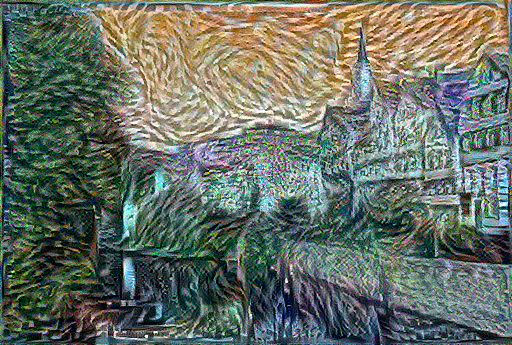

In [98]:
# select the best image which can pass the similarity test with the provided sample styled image
best=imgs[9]
Image.fromarray(best)

In [99]:
best.shape #Just note the shape of output image (345, 512, 3)

(345, 512, 3)

Since there can be variety of stylized outputs we have given a wide margin for testing the output. 

In [100]:
#Test stylized images

def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

a=np.array(Image.open(styled_ref))
mse_style_output= mse(a,best)

assert mse_style_output<15000


# Visualize outputs
We "deprocess" the output image in order to remove the processing that was applied to it. 

In [101]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = resize_img(content_path) 
    style = resize_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

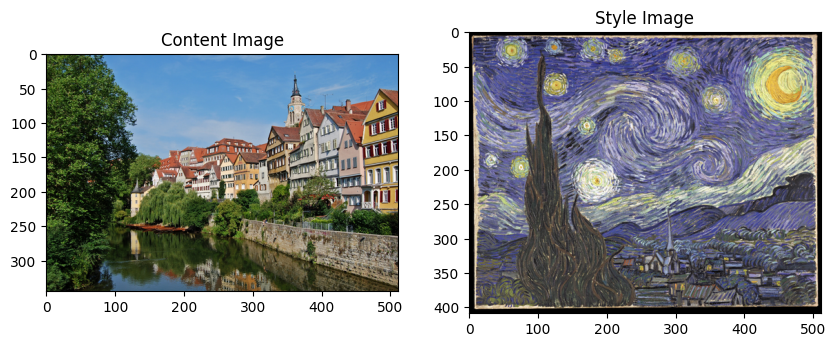

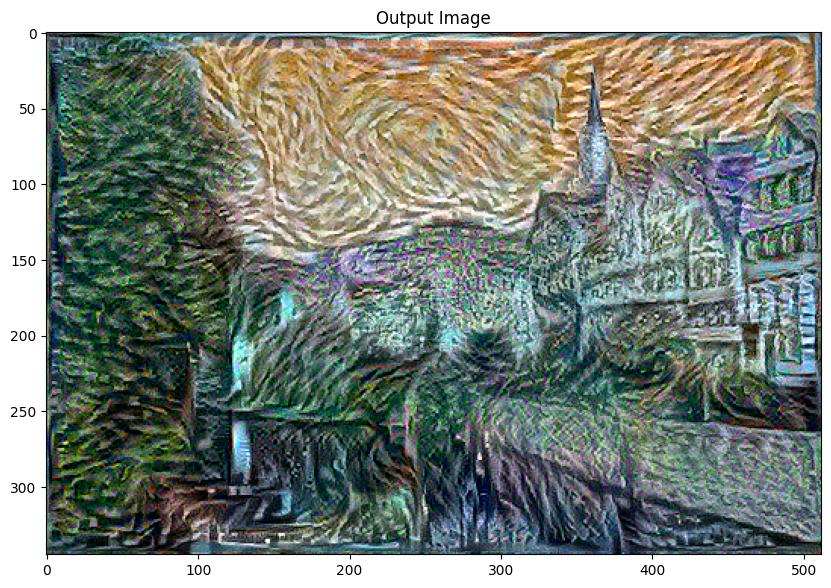

In [102]:
show_results(best, content_path, style_path)